In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import sys
from pathlib import Path
sys.path.append(Path(os.getcwd()).parent.parent.as_posix())

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import dgl
import dgl.nn as dglnn

import optuna

import torch
import torch.nn as nn
import torch.nn.functional as F

from functools import partial
from collections import OrderedDict

from torch import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from dataset import get_datasets, ETTDataset

from utils import seed_everything
from models.gcn import GCNModel

from constructor import construct_ess, construct_vanilla, construct_complete
from graph_features import spectral_features, deepwalk_features

from train import train_step, evaluation_step

import warnings
warnings.simplefilter("ignore")

/home/perkyfever/miniconda3/envs/project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything()

# Config

In [45]:
# LSTF setup
LOOKBACK_SIZE = 96
HORIZON_SIZE = 168

# Graphs setup
GRAPH_CONSTRUCTION_FN = partial(construct_ess, alpha=0.05)
GRAPH_FEATURES_FN = partial(spectral_features, embed_size=7)

# Model setup
BATCH_SIZE = 64
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.50
NUM_HEADS = 2
ACTIVATION_FN = nn.ReLU

# Train setup
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
PATIENCE = 2
LR_FACTOR = 0.5

# Dataset

In [6]:
train_ds, val_ds, test_ds = get_datasets(
    dataset_name="ETTh1.csv",
    lookback_size=LOOKBACK_SIZE,
    horizon_size=HORIZON_SIZE
)

In [7]:
class DatasetAdapter(Dataset):
    def __init__(self, dataset: ETTDataset, graph_construction_fn, graph_features_fn=None):
        super().__init__()
        self.graphs: list[dgl.DGLGraph] = []
        self.targets: list[torch.Tensor] = []
        for idx in tqdm(range(len(dataset)), desc="Building graphs"):
            x_data, time_data, y_data = dataset[idx]
            graph = graph_construction_fn(x_data)

            if graph_features_fn:
                graph_features = graph_features_fn(graph)
                graph.ndata["h"] = torch.cat([x_data.T, graph_features], dim=1)
            else:
                graph.ndata["h"] = x_data.T
            
            graph.ndata["h"] = torch.cat([
                graph.ndata["h"],
                time_data.repeat(graph.number_of_nodes(), 1),
            ], dim=1)
            
            self.targets.append(y_data)
            self.graphs.append(graph)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx) -> tuple[dgl.DGLGraph, torch.Tensor]:
        return self.graphs[idx], self.targets[idx]

In [8]:
def graph_collate_fn(batch):
    """
    Custom collate function for batching DGL graphs.
    :param graphs: batch of graphs and targets
    :returns: batched graph, batch of targets
    """
    graphs, targets = zip(*batch)
    targets_tensor = torch.stack(targets, dim=0)
    return dgl.batch(graphs), targets_tensor

In [9]:
train_adapter_ds = DatasetAdapter(
    dataset=train_ds,
    graph_construction_fn=GRAPH_CONSTRUCTION_FN,
    graph_features_fn=GRAPH_FEATURES_FN
)

val_adapter_ds = DatasetAdapter(
    dataset=val_ds,
    graph_construction_fn=GRAPH_CONSTRUCTION_FN,
    graph_features_fn=GRAPH_FEATURES_FN
)

test_adapter_ds = DatasetAdapter(
    dataset=test_ds,
    graph_construction_fn=GRAPH_CONSTRUCTION_FN,
    graph_features_fn=GRAPH_FEATURES_FN
)

Building graphs:   0%|          | 0/8378 [00:00<?, ?it/s]

Building graphs: 100%|██████████| 2618/2618 [00:26<00:00, 97.68it/s] 


In [10]:
train_loader = DataLoader(
    dataset=train_adapter_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=graph_collate_fn
)

val_loader = DataLoader(
    dataset=val_adapter_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=graph_collate_fn
)

test_loader = DataLoader(
    dataset=test_adapter_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=graph_collate_fn
)

In [11]:
INPUT_DIM = next(iter(train_loader))[0].ndata["h"].shape[1]
INPUT_DIM

178

In [46]:
class GraphTSModel(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        num_layers: int,
        horizon_size: int,
        activation_fn: nn.Module,
        dropout: float = 0,
    ) -> "GraphTSModel":
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.activation_fn = activation_fn
        self.dropout = dropout
        self.horizon_size = horizon_size

        self.backbone = GCNModel(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            activation_fn=self.activation_fn,
            dropout=self.dropout
        )

        self.head = nn.Linear(self.hidden_dim, self.horizon_size)
    
    def forward(self, graph, features):
        x = features
        outputs = self.backbone(graph, x)
        tgt_emb = outputs[6::7] # extract OT's embeddings
        outputs = self.head(tgt_emb)
        return outputs

In [47]:
model = GraphTSModel(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    horizon_size=HORIZON_SIZE,
    activation_fn=ACTIVATION_FN,
    dropout=DROPOUT,
)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=LR_FACTOR, patience=PATIENCE)

dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

In [48]:
model.to(device)

report = {
    "train": [], "valid": [], "test": [],
    "score": 1e6, 'epoch': -1
}

pbar = tqdm(range(NUM_EPOCHS))
pbar.set_description("Training")

for epoch in pbar:
    train_output = train_step(
        train_loader=dataloaders["train"],
        model=model,
        optimizer=optimizer,
        loss_fn=criterion,
        device=device
    )
    report["train"].append(train_output)

    validation_output = evaluation_step(
        loader=dataloaders["val"],
        model=model,
        device=device
    )
    report["valid"].append(validation_output)

    test_output = evaluation_step(
        loader=dataloaders["test"],
        model=model,
        device=device
    )
    report["test"].append(test_output)
    
    pbar.set_postfix_str(
        f"[train] mse = {train_output['mse']:.4f} "
        f"[train] mae = {train_output['mae']:.4f} "
        f"[valid] mse = {validation_output['mse']:.4f} "
        f"[valid] mae = {validation_output['mae']:.4f} "
        f"[test]  mse = {test_output['mse']:.4f} "
        f"[test]  mae = {test_output['mae']:.4f}"
    )

    if validation_output["mse"] < report["score"]:
        report["score"] = validation_output["mse"]
        report["epoch"] = epoch
    
    scheduler.step(validation_output["mse"])

model.to("cpu")

Training: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it, [train] mse = 0.2563 [train] mae = 0.0692 [valid] mse = 1.0087 [valid] mae = 0.1486 [test]  mse = 1.0699 [test]  mae = 0.1571]


GraphTSModel(
  (backbone): GCNModel(
    (blocks): ModuleList(
      (0): GCNBlock(
        (gcn): GraphConv(in=178, out=256, normalization=both, activation=None)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (act): ReLU()
        (dropout): Dropout(p=0.5, inplace=False)
        (skip): Linear(in_features=178, out_features=256, bias=True)
      )
      (1): GCNBlock(
        (gcn): GraphConv(in=256, out=256, normalization=both, activation=None)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (act): ReLU()
        (dropout): Dropout(p=0.5, inplace=False)
        (skip): Identity()
      )
    )
  )
  (head): Linear(in_features=256, out_features=168, bias=True)
)

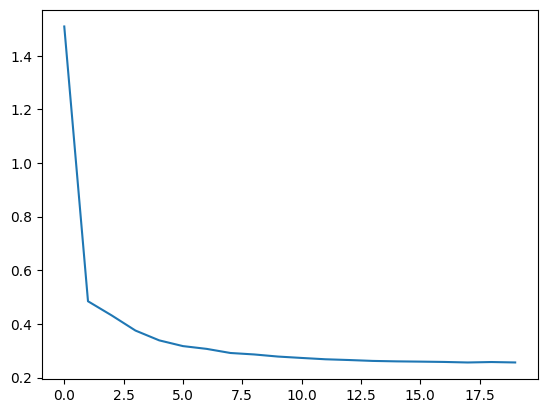

In [49]:
plt.plot([metric["mse"] for metric in report["train"]]);

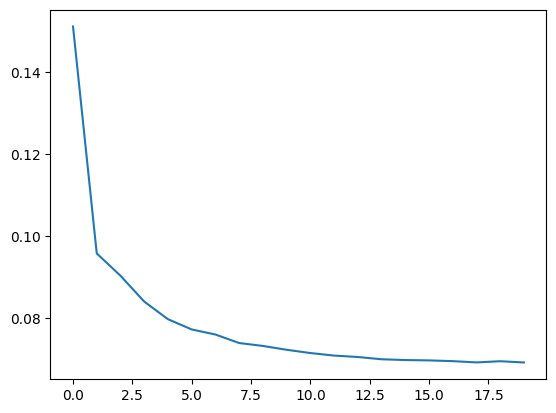

In [50]:
plt.plot([metric["mae"] for metric in report["train"]]);